In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3a
commitnumber = d62b618
conc = 0.0004
dv = 0.001
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

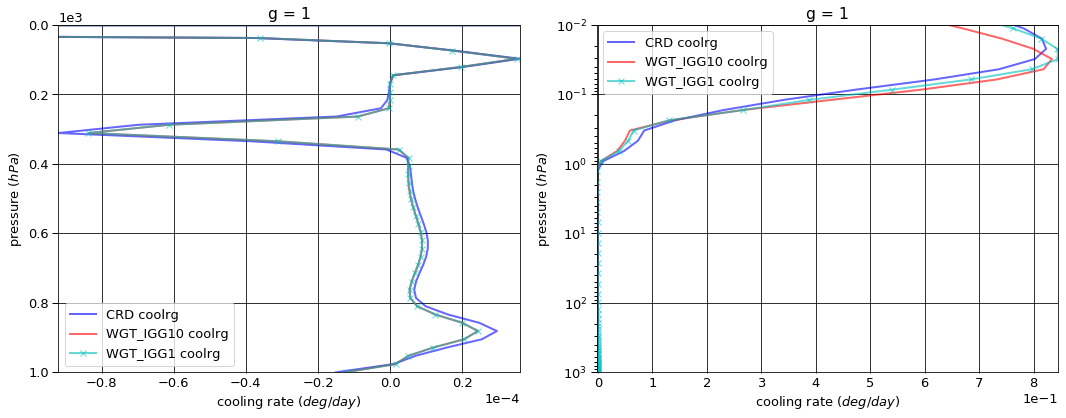

# Figure: cooling rate g-group 2

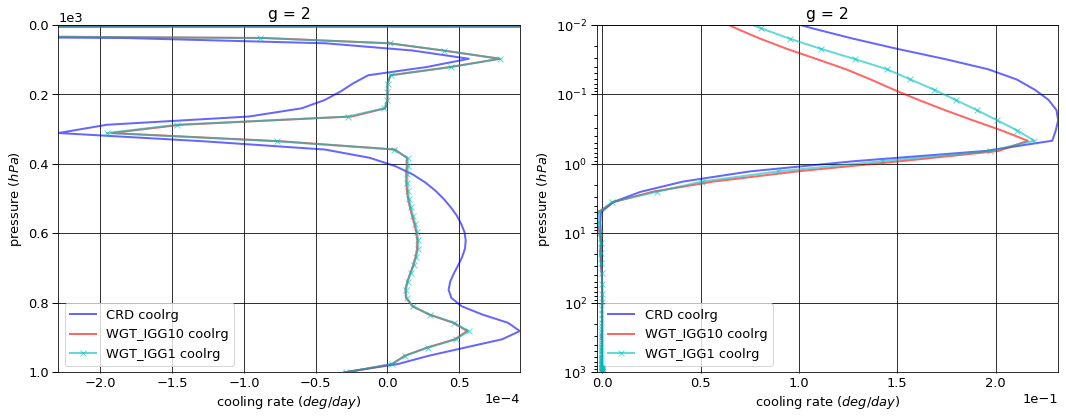

# Figure: cooling rate g-group 3

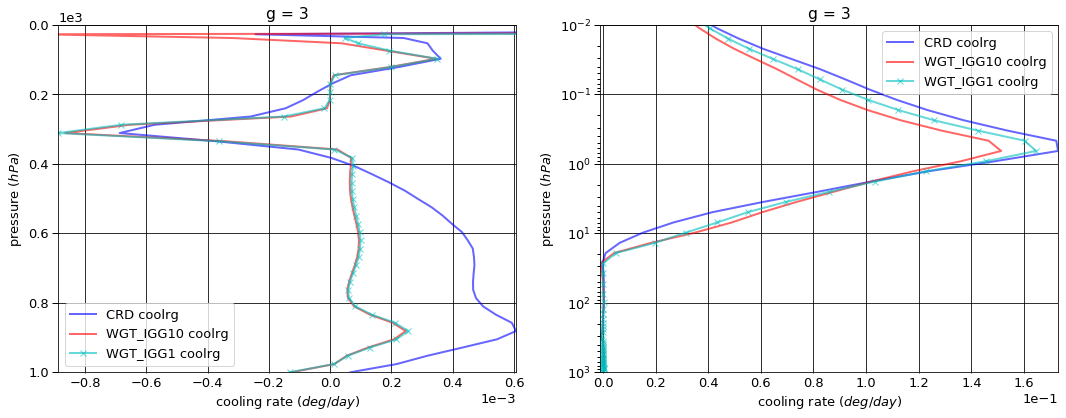

# Figure: cooling rate g-group 4

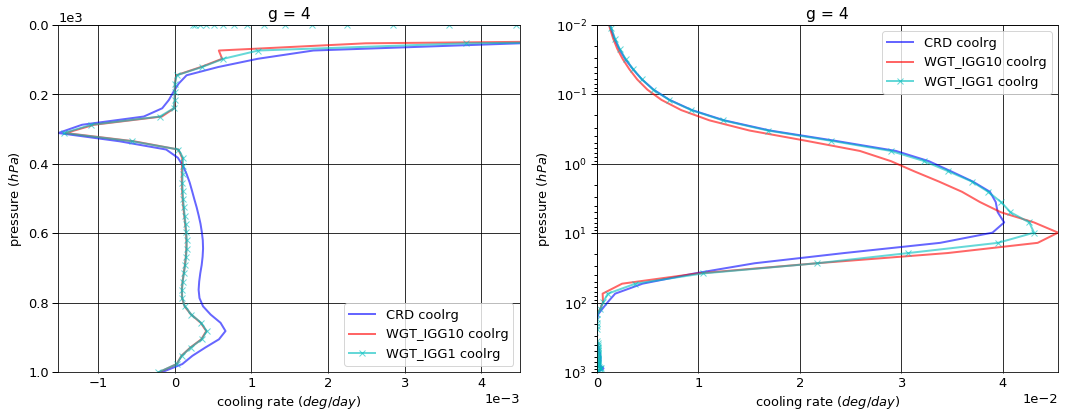

# Figure: cooling rate g-group 5

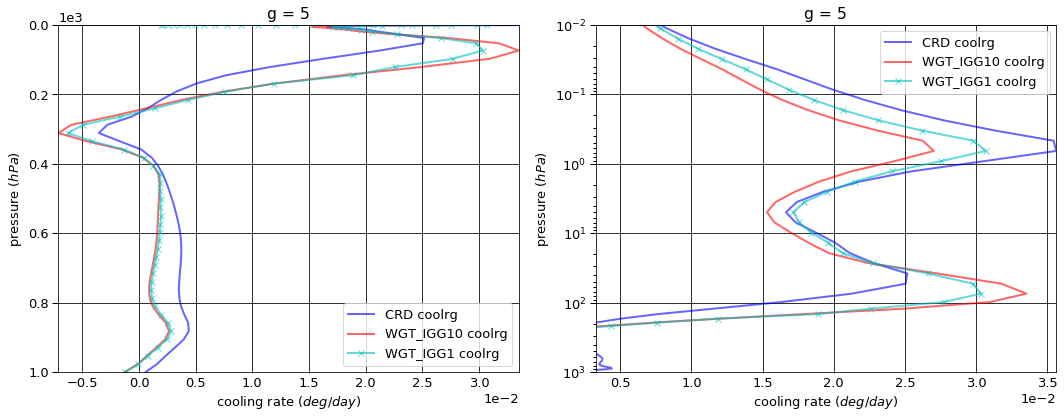

# Figure: cooling rate g-group 6

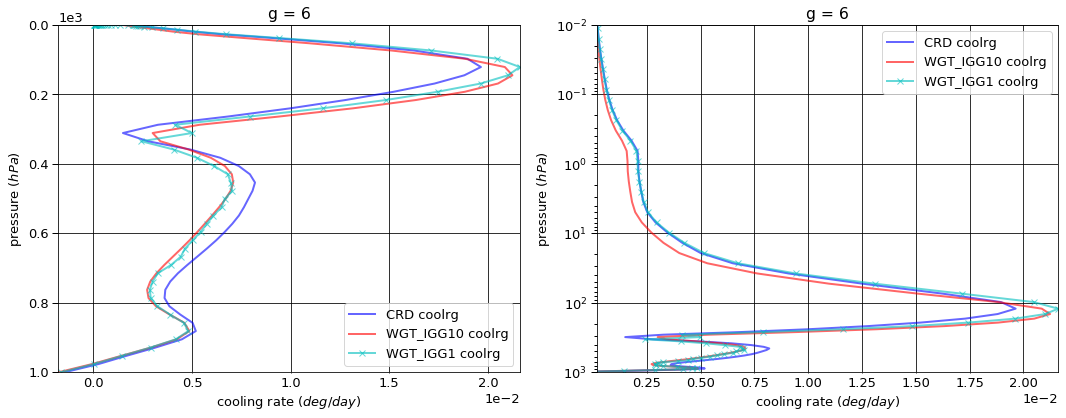

# Figure: cooling rate g-group 7

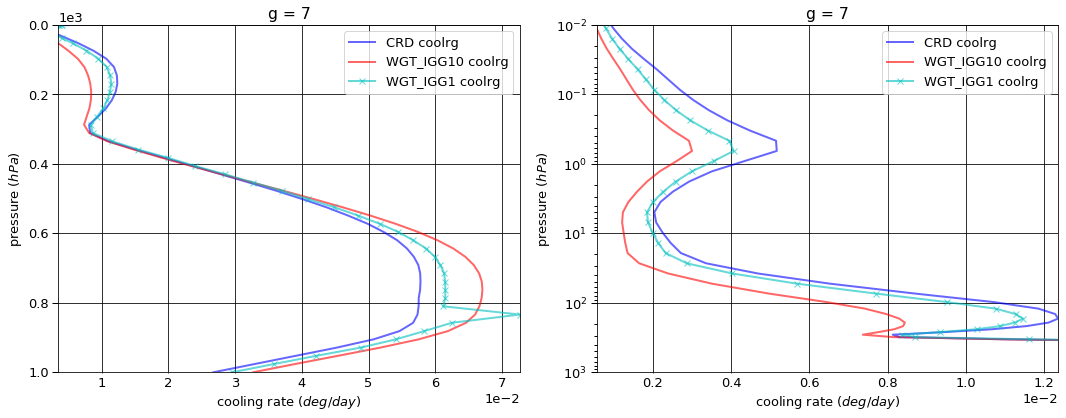

# Figure: cooling rate g-group 8

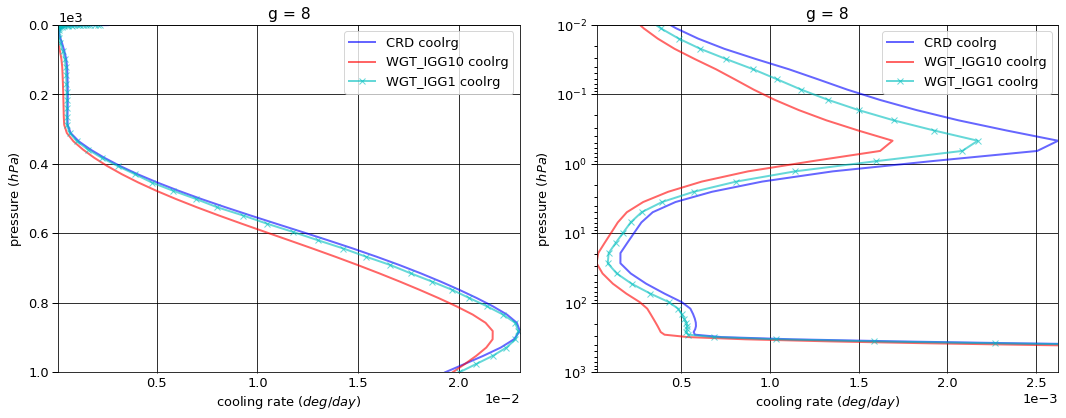

# Figure: cooling rate g-group 9

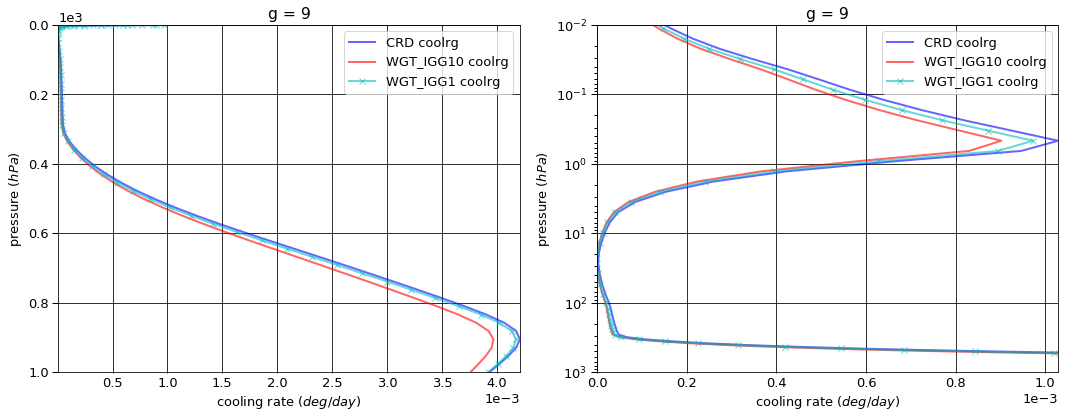

# Figure: cooling rate g-group total

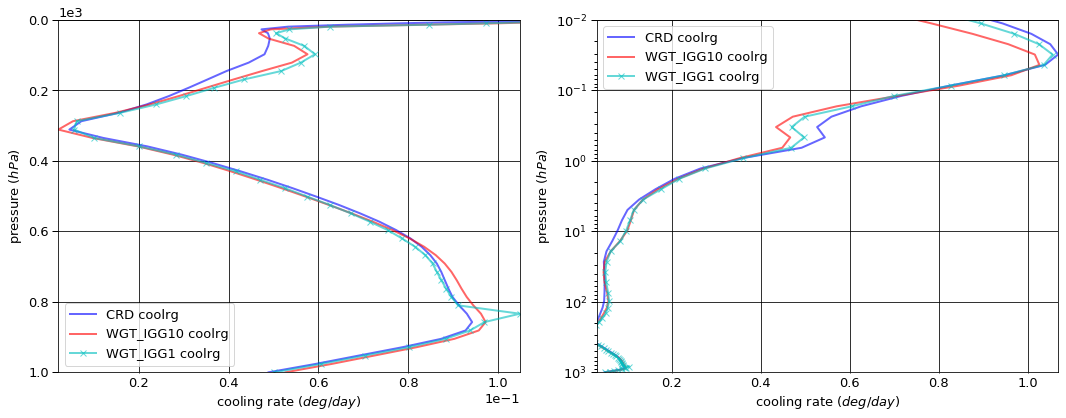

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014625  0.000000 -0.014625
  1013.0   76    -0.017009  0.017109  0.000100
2 0.0      1     -0.031691  0.000000 -0.031691
  1013.0   76    -0.037820  0.038049  0.000229
3 0.0      1     -0.108586  0.000000 -0.108586
  1013.0   76    -0.166003  0.157545 -0.008458
4 0.0      1     -0.150410  0.000000 -0.150410
  1013.0   76    -0.285671  0.285203 -0.000467
5 0.0      1     -0.659599  0.000000 -0.659599
  1013.0   76    -1.098661  1.010933 -0.087729
6 0.0      1     -0.849489  0.000000 -0.849489
  1013.0   76    -1.498911  1.513669  0.014758
7 0.0      1     -4.962093  0.000000 -4.962093
  1013.0   76    -6.243358  5.227749 -1.015608
8 0.0      1     -5.223840  0.000000 -5.223840
  1013.0   76    -5.396115  1.338285 -4.057829
9 0.0      1     -8.830350  0.000000 -8.830350
  1013.0   76    -8.847591  0.207355 -8.640236


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014663  0.000000 -0.014663
  1013.0   76    -0.016932  0.017012  0.000080
2 0.0      1     -0.032081  0.000000 -0.032081
  1013.0   76    -0.037657  0.037839  0.000182
3 0.0      1     -0.101522  0.000000 -0.101522
  1013.0   76    -0.165399  0.166208  0.000809
4 0.0      1     -0.150579  0.000000 -0.150579
  1013.0   76    -0.284420  0.285766  0.001346
5 0.0      1     -0.581319  0.000000 -0.581319
  1013.0   76    -1.095046  1.103838  0.008793
6 0.0      1     -0.838416  0.000000 -0.838416
  1013.0   76    -1.493029  1.508918  0.015888
7 0.0      1     -5.038857  0.000000 -5.038857
  1013.0   76    -6.224318  5.441493 -0.782825
8 0.0      1     -5.258069  0.000000 -5.258069
  1013.0   76    -5.398972  1.195934 -4.203039
9 0.0      1     -8.859439  0.000000 -8.859439
  1013.0   76    -8.875364  0.192236 -8.683128


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.014607  0.000000 -0.014607
  1013.0   76    -0.016932  0.017012  0.000080
2 0.0      1     -0.031964  0.000000 -0.031964
  1013.0   76    -0.037657  0.037842  0.000185
3 0.0      1     -0.101832  0.000000 -0.101832
  1013.0   76    -0.165399  0.166234  0.000836
4 0.0      1     -0.151072  0.000000 -0.151072
  1013.0   76    -0.284420  0.285784  0.001364
5 0.0      1     -0.583165  0.000000 -0.583165
  1013.0   76    -1.095046  1.104544  0.009499
6 0.0      1     -0.841489  0.000000 -0.841489
  1013.0   76    -1.493029  1.508492  0.015463
7 0.0      1     -4.975675  0.000000 -4.975675
  1013.0   76    -6.224318  5.404496 -0.819822
8 0.0      1     -5.232433  0.000000 -5.232433
  1013.0   76    -5.398972  1.315533 -4.083439
9 0.0      1     -8.858273  0.000000 -8.858273
  1013.0   76    -8.875364  0.203566 -8.671798


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000038  0.000000 -0.000038
  1013.0   76     0.000077 -0.000097 -0.000020
2 0.0      1     -0.000390  0.000000 -0.000390
  1013.0   76     0.000162 -0.000210 -0.000047
3 0.0      1      0.007064  0.000000  0.007064
  1013.0   76     0.000604  0.008663  0.009266
4 0.0      1     -0.000169  0.000000 -0.000169
  1013.0   76     0.001251  0.000563  0.001814
5 0.0      1      0.078280  0.000000  0.078280
  1013.0   76     0.003615  0.092906  0.096522
6 0.0      1      0.011073  0.000000  0.011073
  1013.0   76     0.005881 -0.004751  0.001130
7 0.0      1     -0.076764  0.000000 -0.076764
  1013.0   76     0.019040  0.213744  0.232784
8 0.0      1     -0.034229  0.000000 -0.034229
  1013.0   76    -0.002858 -0.142351 -0.145209
9 0.0      1     -0.029089  0.000000 -0.029089
  1013.0   76    -0.027773 -0.015119 -0.042892


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000018  0.000000  0.000018
  1013.0   76     0.000077 -0.000097 -0.000020
2 0.0      1     -0.000273  0.000000 -0.000273
  1013.0   76     0.000162 -0.000206 -0.000044
3 0.0      1      0.006755  0.000000  0.006755
  1013.0   76     0.000604  0.008689  0.009293
4 0.0      1     -0.000662  0.000000 -0.000662
  1013.0   76     0.001251  0.000581  0.001832
5 0.0      1      0.076434  0.000000  0.076434
  1013.0   76     0.003615  0.093612  0.097227
6 0.0      1      0.008000  0.000000  0.008000
  1013.0   76     0.005881 -0.005177  0.000704
7 0.0      1     -0.013582  0.000000 -0.013582
  1013.0   76     0.019040  0.176747  0.195787
8 0.0      1     -0.008593  0.000000 -0.008593
  1013.0   76    -0.002858 -0.022752 -0.025610
9 0.0      1     -0.027923  0.000000 -0.027923
  1013.0   76    -0.027773 -0.003789 -0.031562

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.174027
  1001.112500 75    -0.000015
2 0.000312    1      0.005266
  1001.112500 75    -0.000030
3 0.000312    1      0.006904
  1001.112500 75     0.000066
4 0.000312    1      0.000202
  1001.112500 75    -0.000172
5 0.000312    1      0.001364
  1001.112500 75     0.000550
6 0.000312    1      0.000041
  1001.112500 75    -0.001465
7 0.000312    1      0.000130
  1001.112500 75     0.026732
8 0.000312    1      0.000016
  1001.112500 75     0.019321
9 0.000312    1      0.000001
  1001.112500 75     0.003931


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      9.218190e-02
  1001.112500 75    -1.234080e-05
2 0.000312    1      7.915642e-03
  1001.112500 75    -2.837270e-05
3 0.000312    1      8.179759e-03
  1001.112500 75    -1.267885e-04
4 0.000312    1      2.185709e-04
  1001.112500 75    -2.086624e-04
5 0.000312    1      1.746751e-03
  1001.112500 75    -1.279777e-03
6 0.000312    1      3.349686e-05
  1001.112500 75    -1.778755e-03
7 0.000312    1      6.587499e-05
  1001.112500 75     3.269205e-02
8 0.000312    1     -8.971410e-07
  1001.112500 75     1.969559e-02
9 0.000312    1     -2.690210e-06
  1001.112500 75     3.758897e-03


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.154807
  1001.112500 75    -0.000012
2 0.000312    1      0.007995
  1001.112500 75    -0.000029
3 0.000312    1      0.008343
  1001.112500 75    -0.000132
4 0.000312    1      0.000236
  1001.112500 75    -0.000213
5 0.000312    1      0.001978
  1001.112500 75    -0.001256
6 0.000312    1      0.000044
  1001.112500 75    -0.001642
7 0.000312    1      0.000119
  1001.112500 75     0.029572
8 0.000312    1      0.000009
  1001.112500 75     0.020030
9 0.000312    1     -0.000003
  1001.112500 75     0.003921


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.081845
  1001.112500 75     0.000003
2 0.000312    1      0.002649
  1001.112500 75     0.000002
3 0.000312    1      0.001276
  1001.112500 75    -0.000193
4 0.000312    1      0.000017
  1001.112500 75    -0.000036
5 0.000312    1      0.000383
  1001.112500 75    -0.001830
6 0.000312    1     -0.000008
  1001.112500 75    -0.000314
7 0.000312    1     -0.000064
  1001.112500 75     0.005960
8 0.000312    1     -0.000017
  1001.112500 75     0.000375
9 0.000312    1     -0.000004
  1001.112500 75    -0.000172


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.019219
  1001.112500 75     0.000003
2 0.000312    1      0.002728
  1001.112500 75     0.000001
3 0.000312    1      0.001439
  1001.112500 75    -0.000198
4 0.000312    1      0.000035
  1001.112500 75    -0.000040
5 0.000312    1      0.000614
  1001.112500 75    -0.001806
6 0.000312    1      0.000003
  1001.112500 75    -0.000177
7 0.000312    1     -0.000011
  1001.112500 75     0.002840
8 0.000312    1     -0.000007
  1001.112500 75     0.000709
9 0.000312    1     -0.000004
  1001.112500 75    -0.000010

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.830683,0.000000,-20.830683
1013.0,76,-23.591138,9.795898,-13.795240



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.874945,0.000000,-20.874945
1013.0,76,-23.591138,9.949244,-13.641894



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.790510,0.000000,-20.790510
1013.0,76,-23.591138,10.043505,-13.547633



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.426244e-02,0.000000,-0.044262
1013.0,76,-7.100000e-08,0.153346,0.153346



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.017262e-02,0.000000,0.040173
1013.0,76,-7.100000e-08,0.247607,0.247607


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.187950
1001.112500,75,0.048918



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.110338
1001.112500,75,0.052712



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.173529
1001.112500,75,0.050239



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.077612
1001.112500,75,0.003794



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.014421
1001.112500,75,0.001321


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000737,0.000718
2,0.001638,0.001596
3,0.007162,0.007011
4,0.012375,0.012056
5,0.047313,0.046418
6,0.064750,0.063288
7,0.268363,0.263841
8,0.227887,0.228856
9,0.369775,0.376216


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.344054e-19
2,2.155925e-20
3,1.982895e-21
4,1.784805e-21
5,1.648433e-22
6,7.248533e-22
7,6.798069e-23
8,6.375599e-24
9,1.011343e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.344054e-19,NaN,0.000737,0.000718,0.000737,0.000718,1.0
2,2.155925e-20,0.091974,0.001638,0.001596,0.002375,0.002314,1.0
3,1.982895e-21,0.091974,0.007162,0.007011,0.009537,0.009325,1.0
4,1.784805e-21,0.900100,0.012375,0.012056,0.021913,0.021381,10.0
5,1.648433e-22,0.092359,0.047313,0.046418,0.069225,0.067799,10.0
6,7.248533e-22,4.397225,0.064750,0.063288,0.133975,0.131087,500.0
7,6.798069e-23,0.093785,0.268363,0.263841,0.402338,0.394928,500.0
8,6.375599e-24,0.093785,0.227887,0.228856,0.630225,0.623784,500.0
9,1.011343e-25,0.015863,0.369775,0.376216,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
